# Specific humidity interpolation

This document discusses best practices for interpolating gridded specific humidity. The focus here is on ECMWF data, but the principles apply to other datasets as well.

Among all meteorology variables, humidity plays a special role in contrail prediction. Generally, contrails will not persist outside of ice super-saturated regions. The energy forcing predictions from CoCiP are themselves extremely sensitive to humidity. Small perturbations in humidity can lead to large changes in radiative forcing.

## ERA5 data

In this notebook, we use the `ERA5ARCO` interface to the publicly available [ARCO ERA5](https://cloud.google.com/storage/docs/public-datasets/era5) "model-level" data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from scipy.interpolate import PchipInterpolator

from pycontrails.core import models
from pycontrails.datalib.ecmwf import ERA5ARCO
from pycontrails.physics import thermo

### Regrid to pressure levels

ERA5 data is often provided at discrete pressure levels. Below we regrid the "model level" data from ARCO ERA5 to discrete pressure levels. The spacing of these vertical pressure levels has been chosen to match common spacing of the ERA5 data.

While gridded forecast and reanalysis data is far from perfect, the coarseness of the gridded product can introduce additional errors when interpolating between pressure levels. A model such as CoCiP will proceed with higher precision as additional pressure levels are included in the met data. **We recommend using the highest resolution data available that you can afford to process.** Many of the interpolation artifacts discussed below become negligible when using pressure levels spaced at 10 hPa or less. At cruising altitudes, this is roughly a vertical resolution of 1000 ft or less.

Below we create both a coarsely and finely spaced pressure level dataset for comparison purposes.

In [2]:
pl_coarse = [100, 150, 200, 250, 300, 350, 400]
pl_fine = [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]

time = "2021-03-14T15"
variables = ["t", "q", "ciwc"]

arco_coarse = ERA5ARCO(time, variables, pl_coarse)
ds_coarse = arco_coarse.open_metdataset().data
ds_coarse.load()

arco_fine = ERA5ARCO(time, variables, pl_fine)
ds_fine = arco_fine.open_metdataset().data
ds_fine.load();

In [3]:
# Add RHi to the datasets
for ds in (ds_coarse, ds_fine):
    ds["rhi"] = thermo.rhi(ds["specific_humidity"], ds["air_temperature"], ds["level"] * 100.0)

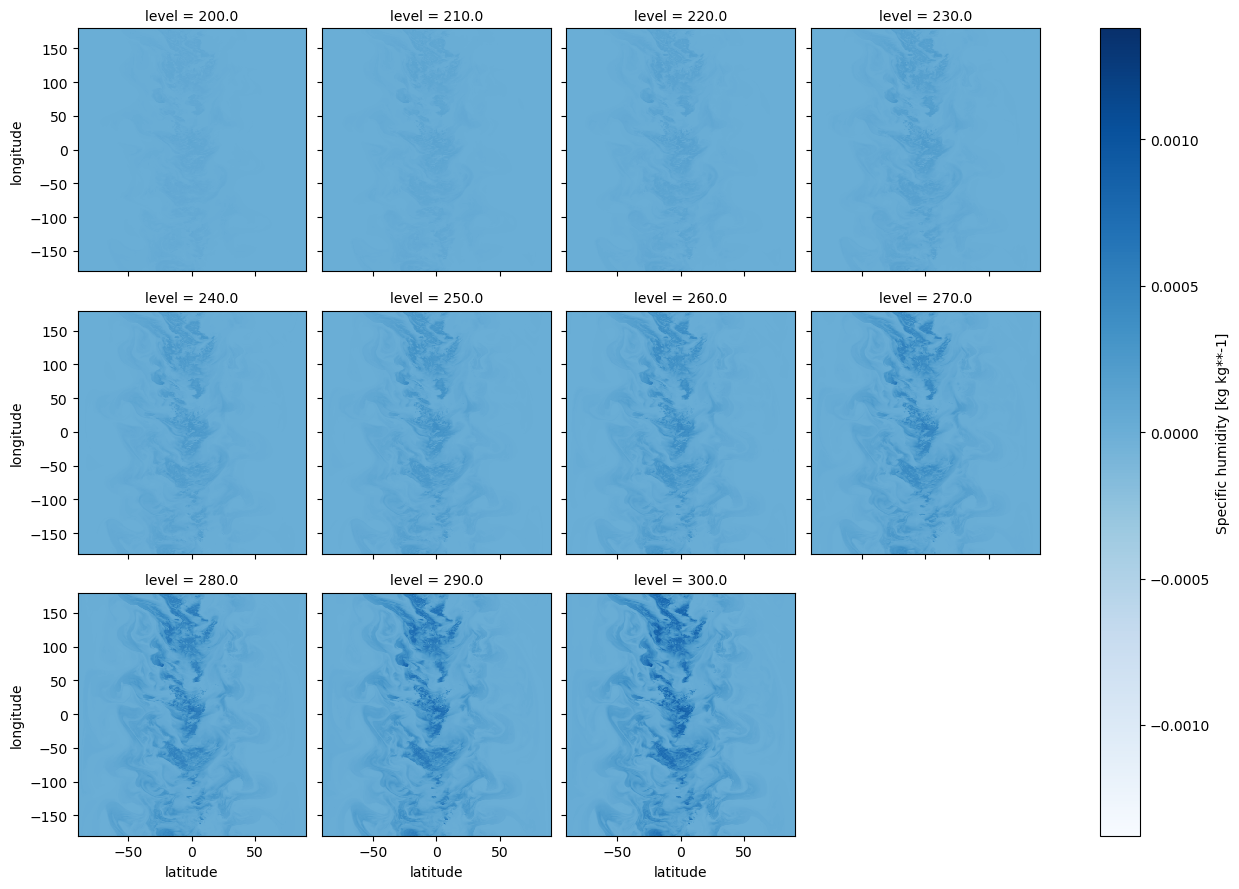

In [4]:
ds_fine["specific_humidity"].squeeze().plot(col="level", col_wrap=4, cmap="Blues");

## Lapse rates

**Lapse rate** typically refers to the rate at which temperature decreases with atmospheric height. Similarly, we can also consider the rate at which specific humidity or cloud ice water content decreases with height. The lapse rate of specific humidity exhibits important differences from the classic temperature lapse rate.

One can use thermodynamics to derive a [theoretical temperature lapse rate](https://en.wikipedia.org/wiki/International_Standard_Atmosphere). Below, we compute the average temperature of the ERA5 data at each pressure level as another way of thinking about the temperature lapse rate.

In [5]:
ds_coarse_mean = ds_coarse.groupby("level").mean(...)
ds_fine_mean = ds_fine.groupby("level").mean(...)

### Temperature lapse rate

Below, we show the mean temperature profile over the entire domain. Importantly, the **temperature profile is roughly linear over the pressure levels** used here.

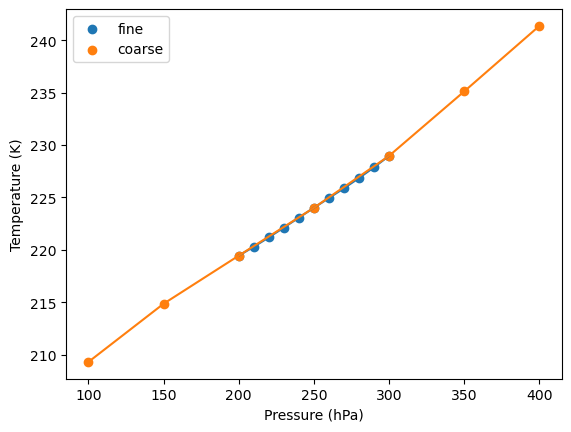

In [6]:
fig, ax = plt.subplots()

ax.scatter(ds_fine_mean["air_temperature"].level, ds_fine_mean["air_temperature"], label="fine")
ax.plot(ds_fine_mean["air_temperature"].level, ds_fine_mean["air_temperature"])

ax.scatter(
    ds_coarse_mean["air_temperature"].level, ds_coarse_mean["air_temperature"], label="coarse"
)
ax.plot(ds_coarse_mean["air_temperature"].level, ds_coarse_mean["air_temperature"])

ax.legend()
ax.set_ylabel("Temperature (K)")
ax.set_xlabel("Pressure (hPa)");

### Specific humidity lapse rate

Make the same plot for specific humidity. Importantly, the specific humidity profile is **nonlinear**. In particular, the plot shows a pronounced upward concavity, primarily because saturation vapor pressure [varies exponentially with temperature](https://en.wikipedia.org/wiki/Clausius%E2%80%93Clapeyron_relation).

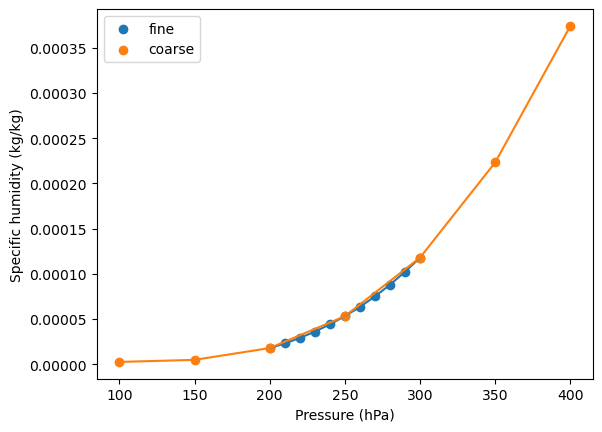

In [7]:
fig, ax = plt.subplots()

ax.scatter(ds_fine_mean["specific_humidity"].level, ds_fine_mean["specific_humidity"], label="fine")
ax.plot(ds_fine_mean["specific_humidity"].level, ds_fine_mean["specific_humidity"])

ax.scatter(
    ds_coarse_mean["specific_humidity"].level, ds_coarse_mean["specific_humidity"], label="coarse"
)
ax.plot(ds_coarse_mean["specific_humidity"].level, ds_coarse_mean["specific_humidity"])

ax.legend()
ax.set_ylabel("Specific humidity (kg/kg)")
ax.set_xlabel("Pressure (hPa)");

### Cloud ice water content lapse rate

Showing the same profile for cloud ice water content. This variable is somewhat less critical because CoCiP does not have a high sensitivity on it. We include it here as a point of comparison.

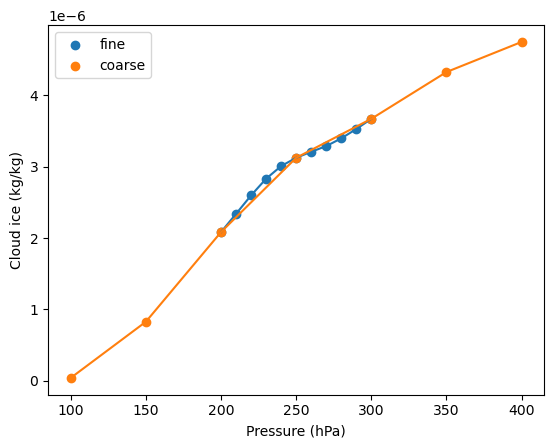

In [8]:
fig, ax = plt.subplots()

ax.scatter(
    ds_fine_mean["specific_cloud_ice_water_content"].level,
    ds_fine_mean["specific_cloud_ice_water_content"],
    label="fine",
)
ax.plot(
    ds_fine_mean["specific_cloud_ice_water_content"].level,
    ds_fine_mean["specific_cloud_ice_water_content"],
)

ax.scatter(
    ds_coarse_mean["specific_cloud_ice_water_content"].level,
    ds_coarse_mean["specific_cloud_ice_water_content"],
    label="coarse",
)
ax.plot(
    ds_coarse_mean["specific_cloud_ice_water_content"].level,
    ds_coarse_mean["specific_cloud_ice_water_content"],
)

ax.legend()
ax.set_ylabel("Cloud ice (kg/kg)")
ax.set_xlabel("Pressure (hPa)");

## The problem

**A nonlinear lapse rate may lead to bias if using linear interpolation.**

Because the specific humidity lapse rate has a positive second derivative, a chord connecting two points on the lapse rate curve will lie above the curve. This means that linear interpolation will tend to overestimate the specific humidity on average at intermediate points.

We demonstrate this below by comparing the coarse and fine pressure level datasets. We also construct a monotonic cubic spline from the coarse pressure level lapse rate as a means of approximating the fine pressure level lapse rate. In particular, this spline approximation is much closer to the fine pressure level lapse rate than a naive linear approximation of the coarse pressure level lapse rate.

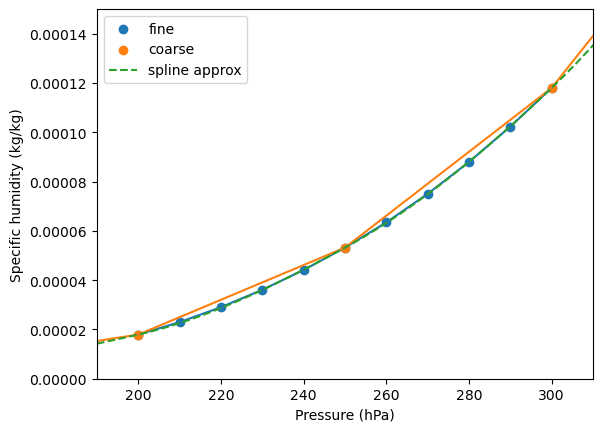

In [9]:
fig, ax = plt.subplots()

ax.scatter(ds_fine_mean["specific_humidity"].level, ds_fine_mean["specific_humidity"], label="fine")
ax.plot(ds_fine_mean["specific_humidity"].level, ds_fine_mean["specific_humidity"])

ax.scatter(
    ds_coarse_mean["specific_humidity"].level, ds_coarse_mean["specific_humidity"], label="coarse"
)
ax.plot(ds_coarse_mean["specific_humidity"].level, ds_coarse_mean["specific_humidity"])

pchip = PchipInterpolator(
    ds_coarse_mean["specific_humidity"].level, ds_coarse_mean["specific_humidity"]
)
p = np.linspace(100, 400, 100)
ax.plot(p, pchip(p), label="spline approx", linestyle="--")
ax.legend()


ax.legend()
ax.set_ylabel("Specific humidity (kg/kg)")
ax.set_xlabel("Pressure (hPa)")

ax.set_xlim(190, 310)
ax.set_ylim(0, 0.00015);

Below, we ignore the fine pressure level dataset lapse rate and only use the coarse pressure level dataset lapse rate to compute an interpolated specific humidity value. In particular, we compare two interpolation methods:

- naive linear interpolation
- monotonic cubic spline interpolation

In light of the previous plot, we expect the monotonic cubic spline to better approximate the lapse rate associated to the fine pressure level dataset. The plot below shows that the two interpolation methods can differ by as much as 5%. This error is a significant, and suggests that linear interpolation in specific humidity may lead to a bias in CoCiP when using coarse pressure level met data.

This sort of data omission experiment is pursued more [rigorously below](#Data-omission-experiment).

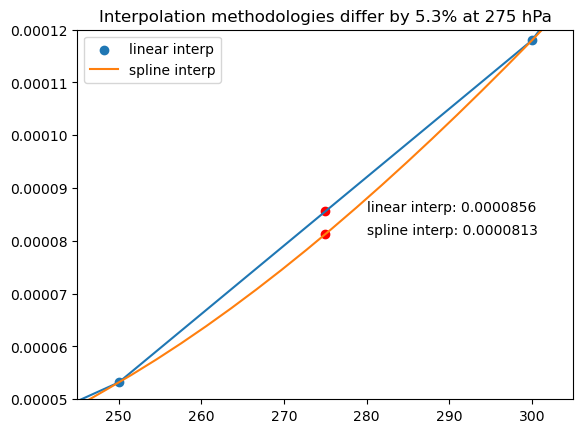

In [10]:
fig, ax = plt.subplots()

ax.scatter(
    ds_coarse_mean["specific_humidity"].level,
    ds_coarse_mean["specific_humidity"],
    label="linear interp",
)
ax.plot(ds_coarse_mean["specific_humidity"].level, ds_coarse_mean["specific_humidity"])

ax.plot(p, pchip(p), label="spline interp")
ax.legend()
ax.set_xlim(245, 305)
ax.set_ylim(0.00005, 0.00012)

p0 = 275
y0 = ds_coarse_mean["specific_humidity"].interp(level=p0).values
y1 = pchip(p0)
pct = (y0 - y1) / y1 * 100.0

ax.scatter([p0, p0], [y0, y1], color="red")
ax.annotate(f"linear interp: {y0:.7f}", (p0, y0), (p0 + 5, y0))
ax.annotate(f"spline interp: {y1:.7f}", (p0, y1), (p0 + 5, y1))
ax.set_title(f"Interpolation methodologies differ by {pct:.1f}% at {p0} hPa");

## Solutions

### Interpolate in the log-log domain

Because both pressure and specific humidity are positive quantities that span several orders of magnitude, it is natural to interpolate in the logarithm of each. Below we plot the lapse rate in the log-log domain. Visibly, the log-log lapse rate is more linear than the lapse rate in the original domain.

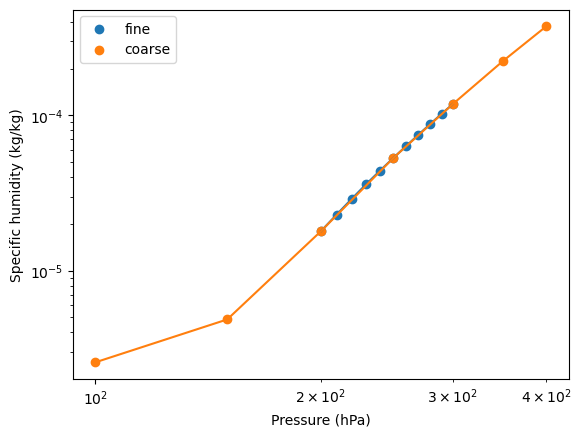

In [11]:
fig, ax = plt.subplots()

ax.scatter(ds_fine_mean["specific_humidity"].level, ds_fine_mean["specific_humidity"], label="fine")
ax.plot(ds_fine_mean["specific_humidity"].level, ds_fine_mean["specific_humidity"])

ax.scatter(
    ds_coarse_mean["specific_humidity"].level, ds_coarse_mean["specific_humidity"], label="coarse"
)
ax.plot(ds_coarse_mean["specific_humidity"].level, ds_coarse_mean["specific_humidity"])

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
ax.set_ylabel("Specific humidity (kg/kg)")
ax.set_xlabel("Pressure (hPa)");

### Use the cubic-spline to linearize the lapse rate

We can manually transform the lapse rate curve by normalizing the pressure domain by the lapse rate. We use the previously computed cubic spline to achieve this. For this approach to be applicable generally, the lapse rate must be monotonic.

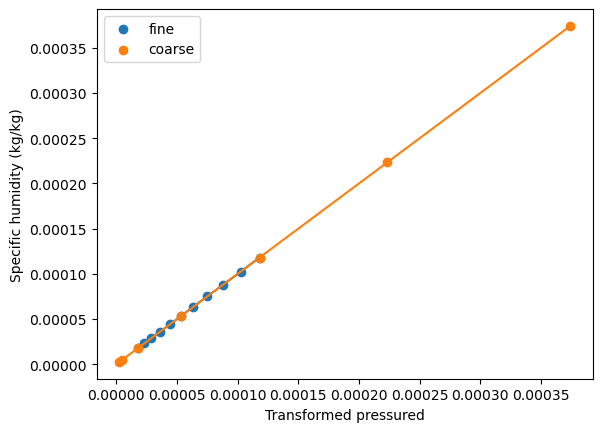

In [12]:
fig, ax = plt.subplots()

ax.scatter(
    pchip(ds_fine_mean["specific_humidity"].level), ds_fine_mean["specific_humidity"], label="fine"
)
ax.plot(pchip(ds_fine_mean["specific_humidity"].level), ds_fine_mean["specific_humidity"])

ax.scatter(
    pchip(ds_coarse_mean["specific_humidity"].level),
    ds_coarse_mean["specific_humidity"],
    label="coarse",
)
ax.plot(pchip(ds_coarse_mean["specific_humidity"].level), ds_coarse_mean["specific_humidity"])

ax.legend()
ax.set_ylabel("Specific humidity (kg/kg)")
ax.set_xlabel("Transformed pressured");

### Interpolate in the gridded RHi space

Gridded relative humidity over ice (RHi) does not exhibit a clear nonlinear lapse rate. Instead of interpolating specific humidity, we could instead interpolate gridded RHi directly. This approach is intuitive to explain, but also has some drawbacks. In particular, the RHi field is not defined in regions where the temperature is above freezing. This means that we would need to use a different interpolation method in these regions.

## Data Omission Experiment

To evaluate each interpolation method, we perform a data omission experiment. For each pressure level in the fine pressure level dataset, we compute the interpolated specific humidity using the coarse pressure level dataset. We then compare this interpolated value to the value in the fine pressure level dataset.

We run this experiment for the four pressure levels 260, 270, 280, and 290 hPa. These are situated between the coarse pressure level dataset levels at 250 and 300 hPa.

### Error metrics

We look at mean squared error (MSE) and mean absolute error (MAE) for each interpolation method. Instead of working with the full dataset, we compute error metrics only near the ISSR threshold. This is the region of the atmosphere where the specific humidity is most important for contrail prediction.

In [13]:
def run_experiment(level):
    """Compute RHi using different interpolation methods."""

    rhi_true = ds_fine["rhi"].sel(level=level)
    t_true = ds_fine["air_temperature"].sel(level=level)

    q_top_bottom = ds_coarse["specific_humidity"].sel(level=[250, 300])
    rhi_top_bottom = ds_coarse["rhi"].sel(level=[250, 300])

    # linear-q interpolation
    tmp = q_top_bottom.interp(level=level)
    linear_q = thermo.rhi(tmp, t_true, level * 100.0)

    # log-q-log-p interpolation
    tmp = q_top_bottom.where(q_top_bottom > 0)
    tmp = np.log(tmp)
    tmp = tmp.assign_coords(level=np.log(tmp["level"]))
    tmp = tmp.interp(level=np.log(level))
    tmp = np.exp(tmp)
    log_q_log_p = thermo.rhi(tmp, t_true, level * 100.0)

    # cubic-spline; using the pre-computed spline in pycontrails
    # the `models._load_spline()` spline was computed in a similar way to the
    # spline created earlier in this notebook
    pchip = models._load_spline()
    tmp = q_top_bottom.assign_coords(level=pchip(q_top_bottom["level"]))
    tmp = tmp.interp(level=pchip(level))
    cubic_spline = thermo.rhi(tmp, t_true, level * 100.0)

    # interp in rhi space
    linear_rhi = rhi_top_bottom.interp(level=level)

    return rhi_true, linear_q, log_q_log_p, cubic_spline, linear_rhi


rhi_true_list = []
linear_q_list = []
log_q_log_p_list = []
cubic_spline_list = []
linear_rhi_list = []

for level in (260, 270, 280, 290):
    rhi_true, linear_q, log_q_log_p, cubic_spline, linear_rhi = run_experiment(level)
    rhi_true_list.append(rhi_true.expand_dims("level"))
    linear_q_list.append(linear_q.expand_dims("level"))
    log_q_log_p_list.append(log_q_log_p.expand_dims("level"))
    cubic_spline_list.append(cubic_spline.expand_dims("level"))
    linear_rhi_list.append(linear_rhi.expand_dims("level"))

rhi_true = xr.concat(rhi_true_list, "level")
linear_q = xr.concat(linear_q_list, "level")
log_q_log_p = xr.concat(log_q_log_p_list, "level")
cubic_spline = xr.concat(cubic_spline_list, "level")
linear_rhi = xr.concat(linear_rhi_list, "level")

### Visualize residuals

- Linear interpolation in q ("linear-q") shows a clear bias in the residuals. This is the same bias previously discussed arising from the "concave up" lapse rate.
- Linear interpolation in the RHi grid ("linear-rhi") shows some bias as well. In particular, the residual mean is further from zero than the other methods.
- Interpolation in the log-log domain ("log-q-log-p") and the cubic spline method ("cubic-spline") both appear promising.

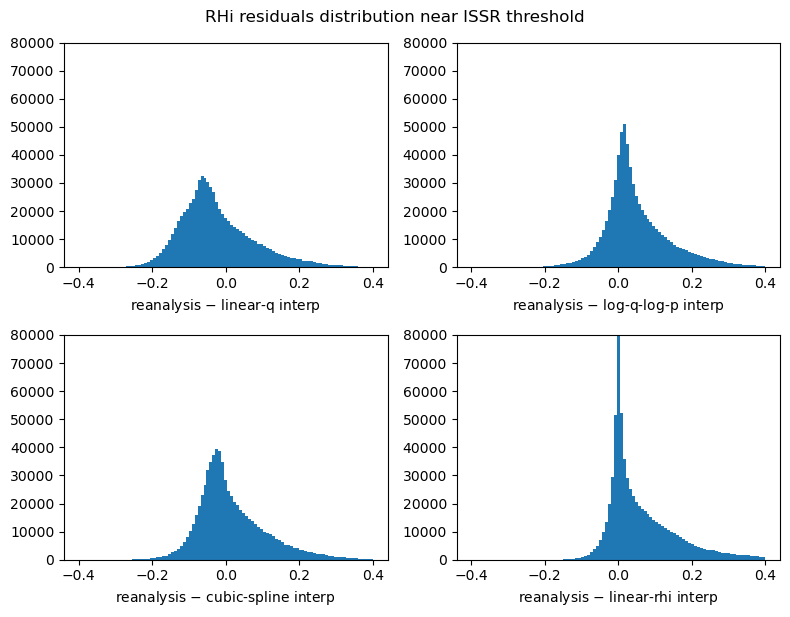

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(8, 6), ncols=2, nrows=2)

bins = np.linspace(-0.4, 0.4, 100)
cond = (rhi_true > 0.9) & (rhi_true < 1.3)

ax1.hist((rhi_true - linear_q).values[cond], bins=bins)
ax2.hist((rhi_true - log_q_log_p).values[cond], bins=bins)
ax3.hist((rhi_true - cubic_spline).values[cond], bins=bins)
ax4.hist((rhi_true - linear_rhi).values[cond], bins=bins)

ax1.set_xlabel("reanalysis $-$ linear-q interp")
ax2.set_xlabel("reanalysis $-$ log-q-log-p interp")
ax3.set_xlabel("reanalysis $-$ cubic-spline interp")
ax4.set_xlabel("reanalysis $-$ linear-rhi interp")

ax1.set_ylim(0, 80000)
ax2.set_ylim(0, 80000)
ax3.set_ylim(0, 80000)
ax4.set_ylim(0, 80000)

plt.tight_layout()
fig.suptitle("RHi residuals distribution near ISSR threshold", y=1.02);

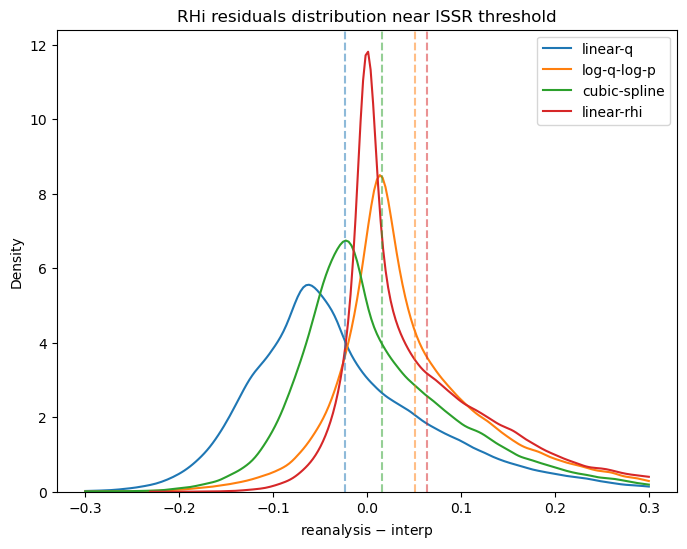

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

clip = -0.3, 0.3

sns.kdeplot((rhi_true - linear_q).values[cond], clip=clip, ax=ax, label="linear-q")
sns.kdeplot((rhi_true - log_q_log_p).values[cond], clip=clip, ax=ax, label="log-q-log-p")
sns.kdeplot((rhi_true - cubic_spline).values[cond], clip=clip, ax=ax, label="cubic-spline")
sns.kdeplot((rhi_true - linear_rhi).values[cond], clip=clip, ax=ax, label="linear-rhi")

ax.axvline((rhi_true - linear_q).values[cond].mean(), color="C0", linestyle="--", alpha=0.5)
ax.axvline((rhi_true - log_q_log_p).values[cond].mean(), color="C1", linestyle="--", alpha=0.5)
ax.axvline((rhi_true - cubic_spline).values[cond].mean(), color="C2", linestyle="--", alpha=0.5)
ax.axvline((rhi_true - linear_rhi).values[cond].mean(), color="C3", linestyle="--", alpha=0.5)

ax.set_title("RHi residuals distribution near ISSR threshold")
ax.set_xlabel("reanalysis $-$ interp")
ax.legend();

### Print error metrics

In [16]:
print(f"MSE linear-q near ISSR:     {np.mean((rhi_true - linear_q).values[cond] ** 2):.4f}")
print(f"MSE log-q-log-p near ISSR:  {np.mean((rhi_true - log_q_log_p).values[cond] ** 2):.4f}")
print(f"MSE cubic-spline near ISSR: {np.mean((rhi_true - cubic_spline).values[cond] ** 2):.4f}")
print(f"MSE linear-rhi near ISSR:   {np.mean((rhi_true - linear_rhi).values[cond] ** 2):.4f}")
print("---")
print(f"MAE linear-q near ISSR:     {np.mean(np.abs(rhi_true - linear_q).values[cond]):.4f}")
print(f"MAE log-q-log-p near ISSR:  {np.mean(np.abs(rhi_true - log_q_log_p).values[cond]):.4f}")
print(f"MAE cubic-spline near ISSR: {np.mean(np.abs(rhi_true - cubic_spline).values[cond]):.4f}")
print(f"MAE linear-rhi near ISSR:   {np.mean(np.abs(rhi_true - linear_rhi).values[cond]):.4f}")

MSE linear-q near ISSR:     0.0112
MSE log-q-log-p near ISSR:  0.0110
MSE cubic-spline near ISSR: 0.0092
MSE linear-rhi near ISSR:   0.0138
---
MAE linear-q near ISSR:     0.0848
MAE log-q-log-p near ISSR:  0.0722
MAE cubic-spline near ISSR: 0.0697
MAE linear-rhi near ISSR:   0.0753


## Conclusions

- When working with gridded met data, use a finer vertical resolution if possible. Using pressure levels spaced at 10 hPa or less at cruising altitudes is recommended for running CoCiP with high precision.
- Linear interpolation in specific humidity appears to introduce bias when working with gridded met data having coarse pressure levels. This bias can be reduced by using more pressure levels.
- Interpolating in the log-log domain appears to be a good solution. An experimental implementation of this is available in `pycontrails` by setting the model parameter `interpolation_q_method="log-q-log-p"`.
- Interpolating with a monotonic cubic spline transformation of the lapse rate also appears to be a good solution. Similarly, this is experimentally available in `pycontrails` by setting a model parameter `interpolation_q_method="cubic-spline"`.
- Interpolating in the gridded RHi space is another possible solution, but it also introduces bias. This is not directly available in `pycontrails`, but could be implemented by the user.